# Исследование сервиса аренды самокатов GoFast

**Краткое описание:** имеются данные о некоторых пользователях из нескольких городов, а также об их поездках.

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
- без подписки
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- с подпиской Ultra
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.

**Цель проекта:** проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти.

**Описание данных:**

*Пользователи*
- ```user_id``` - уникальный идентификатор пользователя
- ```name``` - имя пользователя
- ```age``` - возраст
- ```city``` - город
- ```subscription_type``` - тип подписки (free, ultra)

*Поездки*
- ```user_id``` - уникальный идентификатор пользователя
- ```distance``` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
- ```duration``` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
- ```date``` - дата совершения поездки

*Подписки*
- ```subscription_type``` - тип подписки
- ```minute_price``` - стоимость одной минуты поездки по данной подписке
- ```start_ride_price``` - стоимость начала поездки
- ```subscription_fee``` - стоимость ежемесячного платежа

**План работы**
1. Изучить данные
2. Предобработать данные
3. Проанализировать данные
4. Объединить данные
5. Подсчитать выручку
6. Проверить гипотезы
7. Построить распределения
8. Оформить выводы

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from math import sqrt

## Шаг 1. Загрузка и изучение данных

In [2]:
users = pd.read_csv('.\\datasets\\users_go.csv')
rides = pd.read_csv('.\\datasets\\rides_go.csv')
subscriptions = pd.read_csv('.\\datasets\\subscriptions_go.csv')

### Users

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


### Rides

In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


### Subscriptions

In [7]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


### Промежуточный вывод

Данные были получены, сохранены в переменные и изучены.

По первичному анализу данных пропусков в них не наблюдается, типы данных столбцов, кроме даты поздки, являются подходящими для хранящихся в них значениях.

## Шаг 2. Предобработка данных

### Приведение типов данных

In [8]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')
rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

Столбец ```data``` был приведен к типу datetime.

### Создание необходимых столбцов

In [9]:
rides['month'] = rides['date'].dt.month
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Был создан столбец ```month```, содержащий месяц поездки.

### Поиск дупликатов

In [10]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [11]:
users.duplicated().sum()

31

In [12]:
f'Процент дупликатов от всех данных: {(users.duplicated().sum() / users.shape[0]):.2%}'

'Процент дупликатов от всех данных: 1.98%'

In [13]:
users = users.drop_duplicates().reset_index(drop=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1534 entries, 0 to 1533
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
dtypes: int64(2), object(3)
memory usage: 60.0+ KB


In [14]:
rides.duplicated().sum()

0

Были найдены явные дубликаты в датафрейме users и удалены.

## Шаг 3. Исследовательский анализ данных

<AxesSubplot:title={'center':'Частота вречаемости городов в данных'}, xlabel='Города', ylabel='Сколько раз встречается город'>

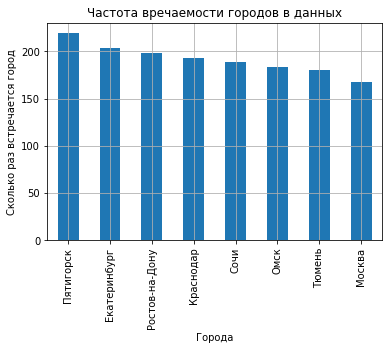

In [15]:
users['city'].value_counts().plot(kind='bar', grid=True,
                                  title='Частота встречаемости городов в данных',
                                  ylabel='Сколько раз встречается город',
                                  xlabel='Города'
                                 )

In [16]:
users['city'].value_counts()

city
Пятигорск         219
Екатеринбург      204
Ростов-на-Дону    198
Краснодар         193
Сочи              189
Омск              183
Тюмень            180
Москва            168
Name: count, dtype: int64

По графику выше можно увидеть, что зарегистрированных пользователей больше всего в Пятигорске, а меньше всего в Москве, но различие не большое, около 50 пользователей.

In [17]:
users['subscription_type'].value_counts(normalize=True)

subscription_type
free     0.544329
ultra    0.455671
Name: proportion, dtype: float64

<AxesSubplot:title={'center':'Сколько пользователей с подпиской и без'}, ylabel='proportion'>

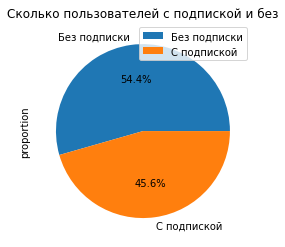

In [18]:
users['subscription_type'].value_counts(normalize=True).plot(kind='pie', legend=True,
                                                             title='Сколько пользователей с подпиской и без', autopct='%1.1f%%',
                                                             labels=['Без подписки', 'С подпиской']
                                                            )

54% пользователей имеют бесплатную подписку, остальные имеют платную подписку.

<AxesSubplot:title={'center':'Гистограмма возраста пользователей'}, xlabel='Возраст', ylabel='Частота'>

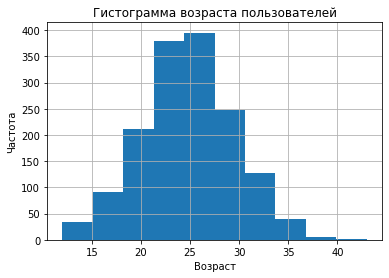

In [19]:
users['age'].plot(kind='hist', grid=True,
                  xlabel='Возраст', ylabel='Частота',
                  title='Гистограмма возраста пользователей'
                 )

In [20]:
users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Данные по возрасту пользователей распределены нормально, больше всего пользователей 22-28 летние, дальше, по мере удаления возраста от этих значений в обе стороны, количнство людей имеющих возраст отличный от 22-28 лет уменьшается.

Меньше всего пользователей, имеющих возраст более 38 лет.

<AxesSubplot:title={'center':'Гистограмма для расстояний, которые проехали пользователи'}, xlabel='Метры', ylabel='Частота'>

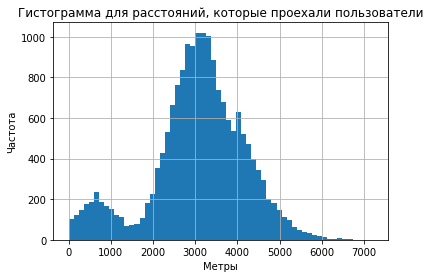

In [21]:
rides['distance'].plot(kind='hist', bins=60, grid=True,
                      ylabel='Частота', xlabel='Метры',
                      title='Гистограмма для расстояний, которые проехали пользователи')

Пользовали в среднем, чаще всего, проезжают около 3км. на самокате, так же имеется небольшой выброс-нормальное распределение, который показывает, что некоторые пользователи берут самокат чтобы проехать около 500 метров, наверное когда им нужно проехаться не на дальнее растояние или просто покататься.

<AxesSubplot:title={'center':'Гистограмма для длительности поездок пользователей'}, xlabel='Минуты', ylabel='Частота'>

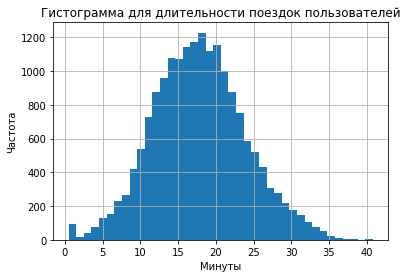

In [22]:
rides['duration'].plot(kind='hist', bins=40, grid=True,
                      ylabel='Частота', xlabel='Минуты',
                      title='Гистограмма для длительности поездок пользователей')

В среднем поездка у пользователей длится около 15-20 минут. Имеется небольшое отклоенение около 1 минуты поездки.

### Промежуточный вывод

- пользователей больше всего из Пятигорска, меньше всего из Москвы;
- 54% пользователей имеют бесплатную подписку, остальные имеют платную подписку;
- больше всего пользователей 22-28 летние;
- пользовали в среднем проезжают около 3км. на самокате;
- в среднем поездка у пользователей длится около 15-20 минут.

## Шаг 4. Объединение данных

In [23]:
data = users.merge(rides, on='user_id')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8


Объединяем датафрейм users и rides в датафрейм data.

In [24]:
data = data.merge(subscriptions, on='subscription_type')
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Объединяем датафрейм data и subscription в датафрейм data.

In [25]:
users_without_subscription = data[data['subscription_type'] == 'free']
users_without_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [26]:
users_with_subscription = data[data['subscription_type'] == 'ultra']
users_with_subscription.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [27]:
data.shape, users_without_subscription.shape, users_with_subscription.shape

((18068, 12), (11568, 12), (6500, 12))

Так же создали 2 новых датасета, которые включают в себя данные о пользователях без подписки и с подпиской.

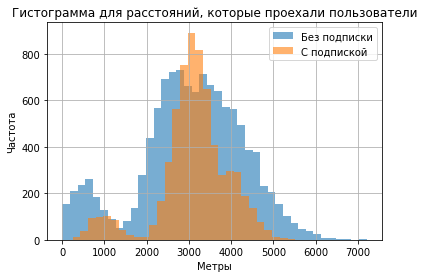

In [28]:
users_without_subscription['distance'].plot(kind='hist', bins=40, grid=True, alpha=0.6,
                                            legend=True, label='Без подписки'
                                           )
users_with_subscription['distance'].plot(kind='hist', bins=30, grid=True, alpha=0.6,
                                         legend=True, label='С подпиской',
                                         xlabel='Метры', ylabel='Частота',
                                         title='Гистограмма для расстояний, которые проехали пользователи'
                                        )
plt.show()

Можно увидеть, что график для пользователей с подпиской имеет меньший разброс в данных, по сравнению с графиком для пользователей без подписки. Возможно пользователи имеющие подписку чаще всего передвигаются до конкретных своих точек, например всегда на работу или учебу.

На графике для пользователей без подписки имеется 2 вершины, что значит, что чаще всего пользователи без подписки прокатывают около 3 км., и чуть реже пользователи беру самокат чтоб прокатится около 500 метров.

На графике для пользователей с подпиской имеется также 2 вершины, что значит, что чаще всего пользователи с подпиской прокатывают также около 3 км., и чуть реже пользователи беру самокат чтоб прокатится около 1 км.

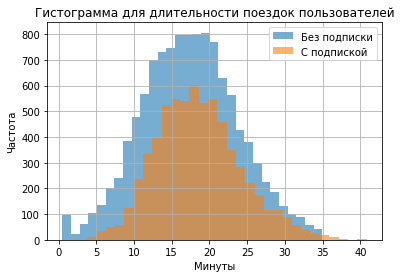

In [29]:
users_without_subscription['duration'].plot(kind='hist', bins=30, grid=True, alpha=0.6,
                                            legend=True, label='Без подписки'
                                           )
users_with_subscription['duration'].plot(kind='hist', bins=30, grid=True, alpha=0.6,
                                         legend=True, label='С подпиской',
                                         xlabel='Минуты', ylabel='Частота',
                                         title='Гистограмма для длительности поездок пользователей'
                                        )
plt.show()

Поездка у пользователей без подписки в среднем длится около 15-20 минут.

Поездка у пользователей с подпиской длится также около 15-20 минут.

У графика пользователей без подписки разброс в данных больше, чем у пользователей с подпиской.

### Промежуточный вывод

Пользователи без подписки и с имеют схожее поведение при аренде самокатов, но пользователи с подпиской чаще берут самокаты на определенные для себя промежутки, возможно на работу или учебу.

## Шаг 5. Подсчёт выручки

In [30]:
data['spent_money_for_rides'] = data['start_ride_price'] + np.ceil(data['duration']) * data['minute_price']
data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,spent_money_for_rides
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,156.0
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,96.0
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,42.0
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,114.0
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,162.0


In [31]:
data_about_rides_and_money = data.pivot_table(
    index=['user_id', 'month'], values=['distance', 'duration', 'spent_money_for_rides'],
    aggfunc={'distance': 'sum', 'duration': 'sum', 'spent_money_for_rides': 'sum', 'user_id': 'count'}
)
data_about_rides_and_money.columns = ['sum_distance', 'sum_duration', 'sum_spent_money_for_rides', 'count_rides']
# добавляем к каждому пользователю абонентскую плату, если он подписан
data_about_rides_and_money['sum_spent_money_for_rides'] += data.groupby(['user_id', 'month'])['subscription_fee'].sum() / data_about_rides_and_money['count_rides']
data_about_rides_and_money.reset_index(inplace=True)
data_about_rides_and_money.head()

,user_id,month,sum_distance,sum_duration,sum_spent_money_for_rides,count_rides
0,1,1,7027.511294,41.416640,451.0,2
1,1,4,754.159807,6.232113,241.0,1
2,1,8,6723.470560,44.776802,475.0,2
3,1,10,5809.911100,31.578017,391.0,2
4,1,11,7003.499363,53.397424,535.0,3


Был создан датафрейм с агрегированными данными о поездках, включающий: суммарное расстояние, количество поездок, помесячная выручка, которую принес каждый пользователь, и суммарное время для каждого пользователя за каждый месяц.

## Шаг 6. Проверка гипотез

### Проверка гипотезы 1. Тратят ли пользователи с подпиской больше времени на поездки?

**Нулевая гипотеза:** средние значения продолжительности поездки у пользователей с подпиской и без равны.

**Алтернативная гипотеза:** среднее значение продолжительности поездки у пользователей с подпиской больше, чем среднее значение продолжителньости поездки у пользователей без подписки.

Параметр ```equal_var``` для теста я установила в False, так как по графику видно, что разброс у графиков разный.
(даже если установить в True, тест отвергнет нулевую гипотезу)

In [32]:
alpha = 0.05

results = st.ttest_ind(users_with_subscription['duration'], users_without_subscription['duration'], equal_var=False, alternative='greater')

print('Pvalue: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

Pvalue:  5.675781377128977e-37
Отвергаем нулевую гипотезу


Есть основания говорить, что пользователи с подпиской больше времени тратят на поездки по сравнению с пользователями без подписки!

### Проверка гипотезы 2. Проезжают ли пользователи с подпиской за одну поездку больше 3130 метров?

**Нулевая гипотеза:** среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров.

**Алтернативная гипотеза:** среднее расстояние, которое проезжают пользователи с подпиской за одну поездку превышает 3130 метров.

In [33]:
alpha = 0.05

optimal_distance = 3130

results = st.ttest_1samp(users_with_subscription['distance'], optimal_distance, alternative='greater')

print('Pvalue: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергать нулевую гипотезу')

Pvalue:  0.9195368847849785
Нет оснований отвергать нулевую гипотезу


Есть основания говорить, что пользователи с подпиской за одну поездку проезжают 3130 метров в среднем.

Нет отснований полагать, что пользователи с подпиской за одну поездку проезжают больше 3130 метров.

### Проверка гипотезы 3. Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

In [34]:
data_about_rides_and_money = data_about_rides_and_money.merge(data[['user_id', 'month', 'subscription_type']], on=['user_id', 'month'])
data_about_rides_and_money.head()

,user_id,month,sum_distance,sum_duration,sum_spent_money_for_rides,count_rides,subscription_type
0,1,1,7027.511294,41.416640,451.0,2,ultra
1,1,1,7027.511294,41.416640,451.0,2,ultra
2,1,4,754.159807,6.232113,241.0,1,ultra
3,1,8,6723.470560,44.776802,475.0,2,ultra
4,1,8,6723.470560,44.776802,475.0,2,ultra


Добавим в таблицу с выручкой столбец с данными по типу подписки для каждого пользователя.

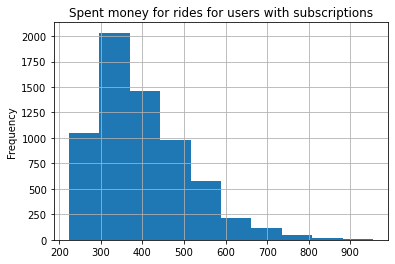

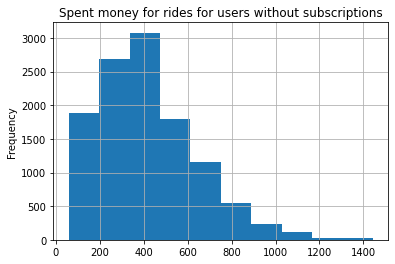

In [35]:
data_about_rides_and_money.query('subscription_type == "ultra"')['sum_spent_money_for_rides'].plot(
    kind='hist', grid=True, title='Spent money for rides for users with subscriptions'
)
plt.show()
data_about_rides_and_money.query('subscription_type == "free"')['sum_spent_money_for_rides'].plot(
    kind='hist', grid=True, title='Spent money for rides for users without subscriptions'
)
plt.show()

По графикам можно увидеть что разброс данных не сильно различается.

Так же предварительно можно заметить, что пользователи без подписки тратят в среднем больше денег на поездки.

**Нулевая гипотеза:** средние значения помесячной выручки для пользователей с подпиской и без подписки одинаковы.

**Алтернативная гипотеза:** среднее значение помесячной выручки для пользователей с подпиской больше, чем среднее значение помесячной выручки для пользователей без подписки.

In [36]:
alpha = 0.05

for month in range(1, 13):
    results = st.ttest_ind(
        data_about_rides_and_money.query('month == @month and subscription_type == "ultra"')['sum_spent_money_for_rides'],
        data_about_rides_and_money.query('month == @month and subscription_type == "free"')['sum_spent_money_for_rides'],
        alternative='greater'
    )

    print('Pvalue: ', results.pvalue)

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу для месяца', month)
    else:
        print('Нет оснований отвергать нулевую гипотезу для месяца', month)

Pvalue:  0.6841297292269042
Нет оснований отвергать нулевую гипотезу для месяца 1
Pvalue:  0.9949238774849607
Нет оснований отвергать нулевую гипотезу для месяца 2
Pvalue:  0.9888626135320185
Нет оснований отвергать нулевую гипотезу для месяца 3
Pvalue:  0.9898413899892002
Нет оснований отвергать нулевую гипотезу для месяца 4
Pvalue:  0.8389200273376516
Нет оснований отвергать нулевую гипотезу для месяца 5
Pvalue:  0.9740653370860037
Нет оснований отвергать нулевую гипотезу для месяца 6
Pvalue:  0.9187638435541551
Нет оснований отвергать нулевую гипотезу для месяца 7
Pvalue:  0.9993513108137787
Нет оснований отвергать нулевую гипотезу для месяца 8
Pvalue:  0.9681411273121675
Нет оснований отвергать нулевую гипотезу для месяца 9
Pvalue:  0.8127165153538547
Нет оснований отвергать нулевую гипотезу для месяца 10
Pvalue:  0.9391101416602814
Нет оснований отвергать нулевую гипотезу для месяца 11
Pvalue:  0.9819746396622085
Нет оснований отвергать нулевую гипотезу для месяца 12


Есть основания говорить, что пользователи с подпиской каждый месяц приносят столько же выручки, сколько и пользователи без подписки.

Нет оснований утверждать, что пользователи с подпиской приносят большую помесячную выручку, чем пользователи без подписки.

### Ответ на вопрос.

**Условия:** техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него.

**Вопрос:** Какой тест вам понадобился бы для проверки этой гипотезы?

Для данной задачи и имеющихся данных можно использовать тест, для проверки гипотезы о равенстве среднего значения для зависимых выборок.

```st.ttest_rel(before, after)```

## Шаг 7. Распределения

### Задача 1. Акция с раздачей промокодов

Отделу маркетинга GoFast поставили **задачу**: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж.

Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей.

**Вопрос:** какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %?

In [37]:
p = 0.1
k = 100

distr = []
for n in range(k, 1500+1):
    current_value = st.binom.cdf(k-1, n, p)
    distr.append(1 - current_value)

В коде выше было построено биномиальное рапределение и вычеслена его комулятивная функция для разных значений *N*, *k = 100* так как нам необходимо найти что от 100 клиентов, включительно 100,  продлят подписку, вероятность возниконовения события = 0.1 или 10%.

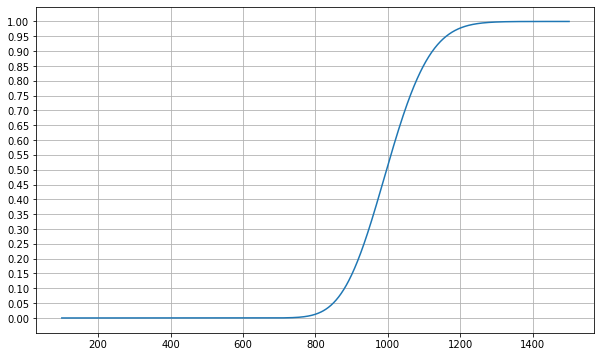

In [38]:
fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
ax.set_yticks(np.arange(0, 1.1, 0.05))
plt.plot(range(k, 1500+1), distr)
plt.grid()
plt.show()

Нам необходимо найти минимальное количество промокодов, которые нужно разослать, чтобы вероятность не выполнить план была примерно 5 % или чтобы вероятность выполнить план была примерно 95%.

По графику видно, что для вероятности 95% нам необходимо разослать **от 1180 промокодов.**

### Задача 2. Push-уведомления в мобильном приложении.

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений.

**Задача:** оцените вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

Так как у нас p (вероятность) не приближена к 1 или 0, а n относительно большое, можно воспользоваться аппроксимацией биномиального распределения к нормальному для расчета вероятности.

In [39]:
n = 1000000
p = 0.4

mu = n*p 
sigma = sqrt(n*p*(1-p))

distr = st.norm(mu, sigma) 

result = distr.cdf(399500)
result

0.15371708296369768

По проведенным выше расчетам можно увидеть, что вероятность, что уведомление откроют менее 399,5 тыс. пользователей **равна примерно 15%.**

## Общий вывод

От заказчика были получены *данные о некоторых пользователях из нескольких городов, а также об их поездках*.

Данные были достаточно хорошего качества, поэтому на этапе предобработки были проделаны следующие дейсвия:
- преведен 1 столбец к типу datetime,
- добавлен новый столбец для расчетов (месяц поездки),
- удалены дубликаты в таблице с пользователями (примерно 2% от всех данных).

Далее был проведен **исследовательский анализ данных**, в ходе которого **было выяснено:**
- пользователей больше всего из Пятигорска, а меньше всего из Москвы, но различие не большое, около 50 пользователей;
- 54% пользователей имеют бесплатную подписку, остальные имеют платную подписку;
- больше всего пользователей 22-28 летние;
- пользовали в среднем проезжают около 3км. на самокате;
- в среднем поездка у пользователей длится около 15-20 минут.

Далее был этап объединения данных и расмотренние пользователей с подпиской и без отдельно.

**Вывод:** пользователи без подписки и с имеют схожее поведение при аренде самокатов, но пользователи с подпиской чаще берут самокаты на определенные для себя промежутки, возможно на работу или учебу.

На следующем этапе была создана таблица на основе имеющихся данных с помесячной выручкой по каждому клиенту. И на основе этих данных был проведен статистический анализ.

В ходе **статистического анализа** были проверены гипотезы и **на основе результатов можно говорить, что**:
- пользователи с подпиской больше времени тратят на поездки по сравнению с пользователями без подписки;
- нет отснований полагать, что пользователи с подпиской за одну поездку проезжают больше 3130 метров;
- нет оснований утверждать, что пользователи с подпиской приносят большую помесячную выручку, чем пользователи без подписки.

Дополнительно были проведены расчеты по распределениям, по которым можно сказать следующее:
- 1180 промокодов нужно разослать, чтобы вероятность не выполнить план по акции с раздачей промокодов на один бесплатный месяц подписки была примерно 5 %;
- при рассылке клиентам 1 млн. push-уведомления в мобильном приложении вероятность того, что уведомление откроют не более 399,5 тыс. пользователей равно примерна 15%.